# Figure. eQTL Summary

In [1]:
import cPickle
import glob
import os
import random
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
from scipy.stats import fisher_exact
import seaborn as sns
import tabix
import vcf as pyvcf
import weblogolib as logo

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_eqtl_summary'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
sns.set_style('whitegrid')

In [3]:
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
fn = os.path.join(dy, 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)

fn = '/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_processing/no_peer_no_std_norm01/h2.tsv'
h2 = pd.read_table(fn, index_col=0, header=None, squeeze=True)

fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
exp = pd.read_table(fn, index_col=0)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'lead_variants.tsv')
lead_vars = pd.read_table(fn, index_col=0)
sig = lead_vars[lead_vars.perm_sig]

fn = os.path.join(ciepy.root, 'output', 'gtex_analysis', 'plot_data.tsv')
plotd = pd.read_table(fn, index_col=0)
plotd = plotd.drop('Testis')
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)

In [5]:
fn = os.path.join(ciepy.root, 'private_output', 'eqtl_input', 
                  'filtered_all', '0000.vcf.gz')
vcf_reader = pyvcf.Reader(open(fn), compressed=True)
res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'eqtls01', 
                                 'gene_results', '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])

qvalue_sig = qvalues[qvalues.perm_sig == 1]
qvalue_sig = qvalue_sig.sort_values('perm_qvalue')

In [6]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
resid_exp = pd.read_table(fn, index_col=0)

In [7]:
log_exp = np.log10(exp + 1)
#log_exp = (log_exp.T - log_exp.mean(axis=1)).T
log_exp = log_exp[rna_meta[rna_meta.in_eqtl].index]
log_exp.columns = rna_meta[rna_meta.in_eqtl].wgs_id

In [8]:
# Example genes. TODO: add in two genes from GO category.
pgenes = ['IDO1', 'LCK', 'POU5F1', 'CXCL5', 'BCL9', 'FGFR1']
pgenes = ['POU5F1', 'CXCL5', 'BCL9', 'FGFR1']
genes = []
for g in pgenes:
    i = gene_info[gene_info.gene_name == g].index[0]
    if i in qvalues[qvalues.perm_sig].index:
        genes.append(i)

In [9]:
pdf = gene_info.ix[genes]
t_h2 = []
t_r2 = []
for g in pdf.index:
    fn = os.path.join(ciepy.root, 'private_output/run_eqtl_analysis/no_peer_no_std_norm01/gene_results', 
                      g, '{}.tsv'.format(g))
    res = ciepy.read_emmax_output(fn)
    res = res.sort_values('PVALUE')
    t_r2.append(res.R2.values[0])
    fn = os.path.join(ciepy.root, 'private_output/run_eqtl_analysis/no_peer_no_std_norm01/gene_results', 
                      g, '{}.reml'.format(g))
    t_h2.append(pd.read_table(fn, index_col=0, header=None, squeeze=True)['h2'])
pdf['r2'] = t_r2
pdf['h2'] = t_h2
pdf

,gene_name,gene_type,chrom,start,end,strand,gene_status,source,level,r2,h2
gene_id,,,,,,,,,,,
ENSG00000204531.11,POU5F1,protein_coding,chr6,31132118,31148508,-,KNOWN,HAVANA,1,0.19070,0.799549
ENSG00000163735.6,CXCL5,protein_coding,chr4,74861358,74864496,-,KNOWN,HAVANA,2,0.18400,0.799549
ENSG00000116128.5,BCL9,protein_coding,chr1,147013181,147098017,+,KNOWN,HAVANA,2,0.05624,0.715645
ENSG00000077782.15,FGFR1,protein_coding,chr8,38268655,38326352,-,KNOWN,HAVANA,1,0.10060,0.166605


In [10]:
def eqtl_violin(gene_id, exp, ax):
    res = ciepy.read_emmax_output(res_fns[gene_id])
    res = res.sort_values('PVALUE')
    t =  vcf_reader.fetch(res.CHROM.values[0], 
                          res.BEG.values[0], 
                          res.BEG.values[0] + 1)
    r = t.next()
    tdf = pd.DataFrame(exp.ix[gene_id])
    tdf.columns = ['Expression']
    tdf['Genotype'] = 0
    hets = set(exp.columns) & set([s.sample for s in r.get_hets()])
    tdf.ix[hets, 'Genotype'] = 1
    alts = set(exp.columns) & set([s.sample for s in r.get_hom_alts()])
    tdf.ix[alts, 'Genotype'] = 2
    ax = sns.violinplot(x='Genotype', y='Expression', data=tdf, color='grey',
                        order=[0, 1, 2], scale='count', linewidth=0.5)
    ax.set_ylabel('$\\log_{10}$ TPM', fontsize=8)
    for t in ax.get_xticklabels() + ax.get_yticklabels():
        t.set_fontsize(6)
    sns.regplot(x='Genotype', y='Expression', data=tdf, scatter=False, color='red', 
                ci=None, line_kws={'linewidth':0.8})
    ax.set_ylabel('$\\log_{10}$ TPM', fontsize=8)
    ya, yb = plt.ylim()
    ax.set_xlabel('')
    #ax.set_xticklabels(['Homo.\nref.', 'Het.', 'Homo.\nalt.'], fontsize=8)
    ax.set_xticklabels([r.REF + '\n' + r.REF, r.REF + '\n' + str(r.ALT[0]), str(r.ALT[0]) + '\n' + str(r.ALT[0])])
    ax.set_title(gene_info.ix[pdf.index[i], 'gene_name'], fontsize=8, style='italic')
    #ax.set_xlabel('Genotype', fontsize=8)
    return ax

In [11]:
a = gene_info.ix[qvalue_sig.index, 'gene_type'].value_counts()
b = gene_info.ix[qvalues.index, 'gene_type'].value_counts()
gtypes = pd.concat([a, b], axis=1)
gtypes = gtypes.fillna(0)
gtypes.columns = ['Significant', 'Tested']
gtypes['Not significant'] = gtypes.Tested - gtypes.Significant
gtypes.sort_values(by=['Tested'], inplace=True, ascending=True)
gtypes = gtypes.drop('Tested', axis=1)
gtypes.index = [x.replace('_', ' ') for x in gtypes.index]

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/matplotlib/gridspec.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


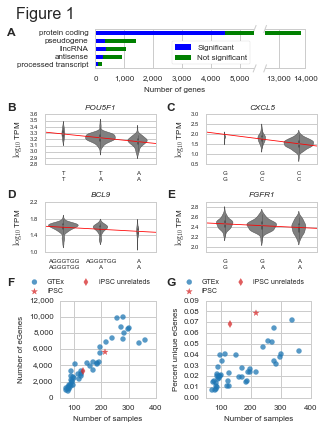

In [12]:
fig = plt.figure(figsize=(4.48, 6.1), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 1, 'Figure 1',
        size=16, va='top')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.95, 0.5, 1])

# eGene types.
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])
ax = fig.add_subplot(gs[0, 0])
gtypes.tail().plot(kind='barh', stacked=True, ax=ax, legend=False, lw=0)
ax.legend(frameon=True, fancybox=True, fontsize=8, loc='lower right')
ax.set_xlim(0, 5500)
ax.grid(axis='y')
ax.xaxis.set_major_formatter(ciepy.comma_format)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('Number of genes', fontsize=8)
sns.despine(ax=ax, top=False)
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
xbreaksize = 0.01 * (xmax - xmin)
ybreaksize = 0.1 * (ymax - ymin)
fudge = 0.001 * (xmax - xmin)
kwargs = dict(lw=1, color='0.8', solid_capstyle='butt', clip_on=False, zorder=0)
ax.plot((xmax + fudge - xbreaksize, xmax + fudge + xbreaksize), 
        (ymin - ybreaksize, ymin + ybreaksize), **kwargs) # top-left diagonal
ax.plot((xmax + fudge - xbreaksize, xmax + fudge + xbreaksize), 
        (ymax - ybreaksize, ymax + ybreaksize), **kwargs) # bottom-left diagonal

# Make top of protein-coding genes.
ax2 = fig.add_subplot(gs[0, 1])
gtypes.tail().plot(kind='barh', stacked=True, ax=ax2, legend=False, lw=0)
sns.despine(ax=ax2, top=False, left=True, right=False)
ax2.set_xlim(12500, 14000)
ax2.set_yticks([])
ax2.grid(axis='y')
ax2.set_xticks([13000, 14000])
ax2.xaxis.set_major_formatter(ciepy.comma_format)
for t in ax2.get_xticklabels() + ax2.get_yticklabels():
    t.set_fontsize(8)
gs.tight_layout(fig, rect=[0, 0.75, 1, 0.95])
xmin,xmax = ax2.get_xlim()
ymin,ymax = ax2.get_ylim()
ax2.plot((xmin - fudge - xbreaksize, xmin - fudge + xbreaksize), 
        (ymin - ybreaksize, ymin + ybreaksize), **kwargs) # bottom-right diagonal
ax2.plot((xmin - fudge - xbreaksize, xmin - fudge + xbreaksize), 
        (ymax - ybreaksize, ymax + ybreaksize), **kwargs) # top-right diagonal

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
i = 0
ax = eqtl_violin(pdf.index[i], log_exp, ax)
ax.set_title(gene_info.ix[pdf.index[i], 'gene_name'], fontsize=8, style='italic')
gs.tight_layout(fig, rect=[0, 0.55, 0.5, 0.78])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
i = 1
ax = eqtl_violin(pdf.index[i], log_exp, ax)
ax.set_title(gene_info.ix[pdf.index[i], 'gene_name'], fontsize=8, style='italic')
gs.tight_layout(fig, rect=[0.5, 0.55, 1, 0.78])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
i = 2
ax = eqtl_violin(pdf.index[i], log_exp, ax)
ax.set_title(gene_info.ix[pdf.index[i], 'gene_name'], fontsize=8, style='italic')
ax.set_yticks(ax.get_yticks()[0::2])
gs.tight_layout(fig, rect=[0, 0.35, 0.5, 0.58])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
i = 3
ax = eqtl_violin(pdf.index[i], log_exp, ax)
gs.tight_layout(fig, rect=[0.5, 0.35, 1, 0.58])

# Number of eGenes vs. number of samples
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(plotd.ix[plotd.source == 'gtex', 'num_samples'], 
           plotd.ix[plotd.source == 'gtex', 'num_sig_genes'],
           label='GTEx', color=cpb.analysis.tableau20[0], s=25, alpha=0.75)
ax.scatter([plotd.ix['ipsc', 'num_samples']], 
           [plotd.ix['ipsc', 'num_sig_genes']],
           label='iPSC', color=cpb.analysis.tableau20[6], alpha=0.75, s=40, marker='*')
ax.scatter([plotd.ix['ipsc_unrelateds', 'num_samples']], 
           [plotd.ix['ipsc_unrelateds', 'num_sig_genes']],
           label='iPSC unrelateds', color=cpb.analysis.tableau20[6], alpha=0.75, s=25, marker='d')
ax.legend(fontsize=7, loc='lower right', ncol=2, bbox_to_anchor=(1, 1))
ax.set_xlabel('Number of samples', fontsize=8)
ax.set_ylabel('Number of eGenes', fontsize=8)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
#ax.legend(frameon=True, fancybox=True, fontsize=7, loc='lower right')
ax.yaxis.set_major_formatter(ciepy.comma_format)
ax.set_xticks(ax.get_xticks()[1::2])
gs.tight_layout(fig, rect=[0, 0, 0.52, 0.34])

# Percent distinct eGenes
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(plotd.ix[plotd.source == 'gtex', 'num_samples'], 
           plotd.ix[plotd.source == 'gtex', 'percent_distinct_egenes'],
           label='GTEx', color=cpb.analysis.tableau20[0], s=25, alpha=0.75)
ax.scatter([plotd.ix['ipsc', 'num_samples']], 
           [plotd.ix['ipsc', 'percent_distinct_egenes']],
           label='iPSC', color=cpb.analysis.tableau20[6], alpha=0.75, s=40, marker='*')
ax.scatter([plotd.ix['ipsc_unrelateds', 'num_samples']], 
           [plotd.ix['ipsc_unrelateds', 'percent_distinct_egenes']],
           label='iPSC unrelateds', color=cpb.analysis.tableau20[6], alpha=0.75, s=25, marker='d')
ax.legend(fontsize=7, loc='lower right', ncol=2, bbox_to_anchor=(1, 1))
ax.set_xlabel('Number of samples', fontsize=8)
ax.set_ylabel('Percent unique eGenes', fontsize=8)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
# ax.legend(frameon=True, fancybox=True, fontsize=7, loc='upper right')
ymin,ymax = ax.get_ylim()
ax.set_ylim(0, ymax)
ax.set_xticks(ax.get_xticks()[1::2])
gs.tight_layout(fig, rect=[0.48, 0, 1, 0.34])

t = fig.text(0.005, 0.91, 'A', weight='bold', 
             size=12)
t = fig.text(0.005, 0.74, 'B', weight='bold', 
             size=12)
t = fig.text(0.5, 0.74, 'C', weight='bold', 
             size=12)
t = fig.text(0.005, 0.54, 'D', weight='bold', 
             size=12)
t = fig.text(0.5, 0.54, 'E', weight='bold', 
             size=12)
t = fig.text(0.005, 0.34, 'F', weight='bold', 
             size=12)
t = fig.text(0.5, 0.34, 'G', weight='bold', 
             size=12)

fig.savefig(os.path.join(outdir, 'eqtl_summary.pdf'))
fig.savefig(os.path.join(outdir, 'eqtl_summary.png'), dpi=300)